# 目的
- ChainerCVのデータセットを生成する
- データ元はjpeg画像とlabelImgで作ったxmlファイル
    - https://github.com/tzutalin/labelImg

## required
- xmltodict
```
$ pip install xmltodict
```


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import glob
import os
import cv2
from PIL import Image

import xmltodict

# BBoxデータを読む

In [2]:
classes_file = 'data/chocoball/classes.txt'
data_dir = 'data/chocoball'

In [3]:
# カテゴリファイル
classes = list()
with open(classes_file) as fd:
    for one_line in fd.readlines():
        cl = one_line.split('\n')[0]
        classes.append(cl)

In [4]:
def getBBoxData(anno_file, classes, data_dir):
    """
    read and parse annotation file(Pascal VOC like XML)
    Args:
        anno_file : file path of annotation file (Pascal VOC like XML)
        classes : list of classes ([class1(str), class2, ...])
        data_dir : data directory path
    Returns:
        dictionaly{img, img_arr, bboxs, obj_names, obj_ids}
            img : image data (PIL object)
            img_arr : image data (nimpy array, [channel, height, width])
    """
    # xmlファイルのパース
    with open(anno_file) as fd:
        pars = xmltodict.parse(fd.read())
    ann_data = pars['annotation']
    # read image
    img = Image.open(os.path.join(data_dir, ann_data['filename']))
    img_arr = np.asarray(img).transpose(2,0,1).astype(np.float32) # Chainer入力用にarrayを変換
    # BoundingBoxとクラス名を読む
    bbox_list = list()
    obj_names = list()
    for obj in ann_data['object']:
        bbox_list.append([obj['bndbox']['ymin'], obj['bndbox']['xmin'], obj['bndbox']['ymax'], obj['bndbox']['xmax']])
        obj_names.append(obj['name'])
    bboxs = np.array(bbox_list, dtype=np.float32)
    obj_names = np.array(obj_names)
    obj_ids = np.array(list(map(lambda x:classes.index(x), obj_names)), dtype=np.int32)
    return {'img':img, 'img_arr':img_arr, 'bboxs':bboxs, 'obj_names':obj_names, 'obj_ids':obj_ids}

##
#ret = getBBoxData(anno_file=anno_files[0], classes=classes, data_dir=data_dir)

In [5]:
def getBBoxDataSet(data_dir, classes):
    """
    Args:
        classes : list of classes ([class1(str), class2, ...])
        data_dir : data directory path
    Returns:
        imgs : image data set ([N, channel, height, width])
        bboxs : list of bounding box [np.array([ymin, xmin, ymax, xmax],[], ...), (), ...]
        obj_ids : object id [np.array([obj_id, ...]), (), ...]
    """
    # get annotetion file list
    os.path.join(data_dir, '*.xml')
    anno_files = glob.glob(os.path.join(data_dir, '*.xml'))
    # 
    img_list = list()
    bboxs = list()
    obj_ids = list()
    for ann_file in anno_files:
        ret = getBBoxData(anno_file=ann_file, classes=classes, data_dir=data_dir)
        img_list.append(ret['img_arr'])
        bboxs.append(ret['bboxs'])
        obj_ids.append(ret['obj_ids'])
    imgs = np.array(img_list)
    return (imgs, bboxs, obj_ids)
##
imgs, bboxs, obj_ids = getBBoxDataSet(data_dir=data_dir, classes=classes)
## save
np.save(os.path.join(data_dir, 'images.npy'), imgs)
np.save(os.path.join(data_dir, 'bounding_box_data.npy'), bboxs)
np.save(os.path.join(data_dir, 'object_ids.npy'), obj_ids)

In [6]:
print(imgs.shape)
print(len(bboxs))
print(len(obj_ids))

(4, 3, 302, 403)
4
4


# ChainerCV用データセットを作る

In [7]:
from chainercv.chainer_experimental.datasets.sliceable import TupleDataset

/home/tokita/.pyenv/versions/anaconda2-4.4.0/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
#imgs = img[np.newaxis,:,:,:]
#dataset = TupleDataset(('img', imgs), ('bbox', [np.array(bbox_list, dtype=np.int32)]), ('label', [np.array(obj_names)]))
dataset = TupleDataset(('img', imgs), ('bbox', bboxs), ('label', obj_ids))

In [9]:
dataset.keys

('img', 'bbox', 'label')

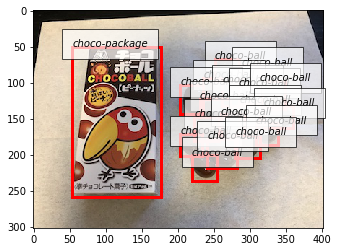

In [10]:
from chainercv.visualizations import vis_bbox
tmp_img, tmp_bboxs, tmp_labels = dataset[0]
vis_bbox(tmp_img, tmp_bboxs, tmp_labels, label_names=classes)
plt.show()

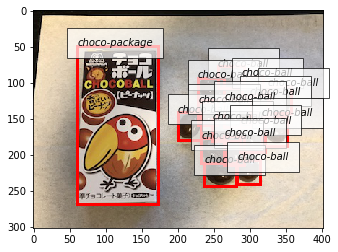

In [11]:
tmp_img, tmp_bboxs, tmp_labels = dataset[1]
vis_bbox(tmp_img, tmp_bboxs, tmp_labels, label_names=classes)
plt.show()

In [12]:
len(dataset)

4